# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
!pip install -q scikit-learn==1.5.0
!pip install -q category_encoders scikit-learn
!pip install -q matplotlib==3.4.3
!pip install -q lightgbm
!pip install -q phik 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import phik
import sklearn
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (mean_squared_error,
                             root_mean_squared_error)
from sklearn.model_selection import (train_test_split, 
                                     GridSearchCV,
                                     cross_val_score)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (OneHotEncoder,  
                                   StandardScaler, 
                                   MinMaxScaler, 
                                   RobustScaler) 
from category_encoders import TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyRegressor
from sklearn.neighbors import KNeighborsRegressor  
from sklearn.tree import  DecisionTreeRegressor  
from sklearn.ensemble import RandomForestRegressor 
import lightgbm as lgbm
from lightgbm import LGBMRegressor
import time

In [2]:
pd.options.display.max_columns = None

In [4]:
list_of_columns_1 = list(df.columns)

In [5]:
for i in range(len(list_of_columns_1)):
    print('\'' + list_of_columns_1[i].lower()+'\',')

'datecrawled',
'price',
'vehicletype',
'registrationyear',
'gearbox',
'power',
'model',
'kilometer',
'registrationmonth',
'fueltype',
'brand',
'repaired',
'datecreated',
'numberofpictures',
'postalcode',
'lastseen',


In [6]:
list_of_columns_2 = ['date_crawled', 'price', 'vehicle_type', 'registration_year', 
                     'gearbox', 'power', 'model', 'kilometer', 'registration_month', 
                     'fuel_type', 'brand', 'repaired', 'date_created', 
                     'number_of_pictures', 'postal_code', 'last_seen']

In [7]:
df = df.set_axis(list_of_columns_2, axis=1)

Рассмотрим основную информацию о датасете

In [8]:
def info_df(df):
    display('Исходный DataFrame')
    display(df.head())
    display('Исходный DataFrame .info()')
    display(df.info())
    display('Исходный DataFrame .isna().sum()')
    display(df.isna().sum())    
    display('Описание распределения по столбцам')
    display(df.describe(include='all').T)
    display('Коэфициенты корреляции')
    display(df.corr(method='spearman')) 
    display('Кол-во  Полные дубликаты')
    display(df.duplicated().sum())

In [9]:
info_df(df)

'Исходный DataFrame'

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


'Исходный DataFrame .info()'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354369 non-null  object
 1   price               354369 non-null  int64 
 2   vehicle_type        316879 non-null  object
 3   registration_year   354369 non-null  int64 
 4   gearbox             334536 non-null  object
 5   power               354369 non-null  int64 
 6   model               334664 non-null  object
 7   kilometer           354369 non-null  int64 
 8   registration_month  354369 non-null  int64 
 9   fuel_type           321474 non-null  object
 10  brand               354369 non-null  object
 11  repaired            283215 non-null  object
 12  date_created        354369 non-null  object
 13  number_of_pictures  354369 non-null  int64 
 14  postal_code         354369 non-null  int64 
 15  last_seen           354369 non-null  object
dtypes:

None

'Исходный DataFrame .isna().sum()'

date_crawled              0
price                     0
vehicle_type          37490
registration_year         0
gearbox               19833
power                     0
model                 19705
kilometer                 0
registration_month        0
fuel_type             32895
brand                     0
repaired              71154
date_created              0
number_of_pictures        0
postal_code               0
last_seen                 0
dtype: int64

'Описание распределения по столбцам'

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
date_crawled,354369,271174,2016-03-24 14:49:47,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
price,354369.0,NaN,NaN,NaN,4416.656776,4514.158514,0.0,1050.0,2700.0,6400.0,20000.0
vehicle_type,316879,8,sedan,91457,NaN,NaN,NaN,NaN,NaN,NaN,NaN
registration_year,354369.0,NaN,NaN,NaN,2004.234448,90.227958,1000.0,1999.0,2003.0,2008.0,9999.0
gearbox,334536,2,manual,268251,NaN,NaN,NaN,NaN,NaN,NaN,NaN
power,354369.0,NaN,NaN,NaN,110.094337,189.850405,0.0,69.0,105.0,143.0,20000.0
model,334664,250,golf,29232,NaN,NaN,NaN,NaN,NaN,NaN,NaN
kilometer,354369.0,NaN,NaN,NaN,128211.172535,37905.34153,5000.0,125000.0,150000.0,150000.0,150000.0
registration_month,354369.0,NaN,NaN,NaN,5.714645,3.726421,0.0,3.0,6.0,9.0,12.0
fuel_type,321474,7,petrol,216352,NaN,NaN,NaN,NaN,NaN,NaN,NaN


'Коэфициенты корреляции'

,price,registration_year,power,kilometer,registration_month,number_of_pictures,postal_code
price,1.000000,0.550988,0.512604,-0.314412,0.155247,NaN,0.078933
registration_year,0.550988,1.000000,0.160182,-0.294567,0.052692,NaN,0.034934
power,0.512604,0.160182,1.000000,0.084509,0.128826,NaN,0.081066
kilometer,-0.314412,-0.294567,0.084509,1.000000,-0.011119,NaN,-0.017086
registration_month,0.155247,0.052692,0.128826,-0.011119,1.000000,NaN,0.014935
number_of_pictures,NaN,NaN,NaN,NaN,NaN,NaN,NaN
postal_code,0.078933,0.034934,0.081066,-0.017086,0.014935,NaN,1.000000


'Кол-во  Полные дубликаты'

4

В наличии  - 354369 rows × 16 columns,

Есть пропуски до 20% по отдельным столбцам:

- vehicle_type          37490 
- gearbox               19833 - Возможно коробка снята
- model                 19705 - Возможно модели не было в выпадающем списке на сайте
- fuel_type             32895 - Возможно многотопливный
- repaired              71154 - Чувствительный параметр, ремонт часто пробуют скрыть 

Приведём столбцы с датой к формату datetime

In [10]:
df['date_crawled'] = pd.to_datetime(df['date_crawled'], format='%Y-%m-%d %H:%M:%S')
df['date_created'] = pd.to_datetime(df['date_created'], format='%Y-%m-%d %H:%M:%S')
df['last_seen'] = pd.to_datetime(df['last_seen'], format='%Y-%m-%d %H:%M:%S')

### Рассмотрим уникальные значения в столбцах и их частоту

In [11]:
def uniq_in_df(df):
    list_of_columns = list(df.columns)
    for col in list(df.columns):
        print('Столбец:', col)
        print('Кол-во уникальных значений:', len(df[col].unique()))
        print('Самые частые и самые редкие значения:')
        display(df.groupby(by=col)[col].count().sort_values(ascending =False))        
        try:
            print('Значения в порядке возрастания:')
            print(np.sort(df[col].unique()))
        except:
            pass

In [12]:
uniq_in_df(df)

Столбец: date_crawled
Кол-во уникальных значений: 271174
Самые частые и самые редкие значения:


date_crawled
2016-03-24 14:49:47    7
2016-03-19 21:49:56    6
2016-03-26 22:57:31    6
2016-03-16 17:43:49    5
2016-04-01 19:25:23    5
                      ..
2016-03-17 20:50:23    1
2016-03-17 20:50:26    1
2016-03-17 20:50:28    1
2016-03-17 20:50:35    1
2016-04-07 14:36:58    1
Name: date_crawled, Length: 271174, dtype: int64

Значения в порядке возрастания:
['2016-03-05T14:06:22.000000000' '2016-03-05T14:06:23.000000000'
 '2016-03-05T14:06:24.000000000' ... '2016-04-07T14:36:55.000000000'
 '2016-04-07T14:36:56.000000000' '2016-04-07T14:36:58.000000000']
Столбец: price
Кол-во уникальных значений: 3731
Самые частые и самые редкие значения:


price
0       10772
500      5670
1500     5394
1000     4649
1200     4594
        ...  
6375        1
6370        1
6365        1
6344        1
5865        1
Name: price, Length: 3731, dtype: int64

Значения в порядке возрастания:
[    0     1     2 ... 19998 19999 20000]
Столбец: vehicle_type
Кол-во уникальных значений: 9
Самые частые и самые редкие значения:


vehicle_type
sedan          91457
small          79831
wagon          65166
bus            28775
convertible    20203
coupe          16163
suv            11996
other           3288
Name: vehicle_type, dtype: int64

Значения в порядке возрастания:
Столбец: registration_year
Кол-во уникальных значений: 151
Самые частые и самые редкие значения:


registration_year
2000    24490
1999    22728
2005    22109
2001    20124
2006    19900
        ...  
2900        1
3200        1
3500        1
3700        1
1255        1
Name: registration_year, Length: 151, dtype: int64

Значения в порядке возрастания:
[1000 1001 1039 1111 1200 1234 1253 1255 1300 1400 1500 1600 1602 1688
 1800 1910 1915 1919 1920 1923 1925 1927 1928 1929 1930 1931 1932 1933
 1934 1935 1936 1937 1938 1940 1941 1942 1943 1944 1945 1946 1947 1948
 1949 1950 1951 1952 1953 1954 1955 1956 1957 1958 1959 1960 1961 1962
 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976
 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990
 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004
 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018
 2019 2066 2200 2222 2290 2500 2800 2900 3000 3200 3500 3700 3800 4000
 4100 4500 4800 5000 5300 5555 5600 5900 5911 6000 6500 7000 7100 7500
 7800 8000 8200 8455 8500 8888 9000 9229 9450 9996 9999]
Столбец: gearbox
Кол-во уникальных значений: 3
Самые частые и самые редкие значения:


gearbox
manual    268251
auto       66285
Name: gearbox, dtype: int64

Значения в порядке возрастания:
Столбец: power
Кол-во уникальных значений: 712
Самые частые и самые редкие значения:


power
0        40225
75       24023
60       15897
150      14590
101      13298
         ...  
1317         1
1324         1
1339         1
1351         1
20000        1
Name: power, Length: 712, dtype: int64

Значения в порядке возрастания:
[    0     1     2     3     4     5     6     7     8     9    10    11
    12    13    14    15    16    17    18    19    20    21    22    23
    24    25    26    27    28    29    30    31    32    33    34    35
    36    37    38    39    40    41    42    43    44    45    46    47
    48    49    50    51    52    53    54    55    56    57    58    59
    60    61    62    63    64    65    66    67    68    69    70    71
    72    73    74    75    76    77    78    79    80    81    82    83
    84    85    86    87    88    89    90    91    92    93    94    95
    96    97    98    99   100   101   102   103   104   105   106   107
   108   109   110   111   112   113   114   115   116   117   118   119
   120   121   122   123   124   125   126   127   128   129   130   131
   132   133   134   135   136   137   138   139   140   141   142   143
   144   145   146   147   148   149   150   151   152   153   154   155
   156   157   158 

model
golf                  29232
other                 24421
3er                   19761
polo                  13066
corsa                 12570
                      ...  
serie_2                   8
serie_3                   4
rangerover                4
range_rover_evoque        2
serie_1                   2
Name: model, Length: 250, dtype: int64

Значения в порядке возрастания:
Столбец: kilometer
Кол-во уникальных значений: 13
Самые частые и самые редкие значения:


kilometer
150000    238209
125000     36454
100000     14882
90000      11567
80000      10047
70000       8593
60000       7444
5000        6397
50000       6232
40000       4911
30000       4436
20000       3975
10000       1222
Name: kilometer, dtype: int64

Значения в порядке возрастания:
[  5000  10000  20000  30000  40000  50000  60000  70000  80000  90000
 100000 125000 150000]
Столбец: registration_month
Кол-во уникальных значений: 13
Самые частые и самые редкие значения:


registration_month
0     37352
3     34373
6     31508
4     29270
5     29153
7     27213
10    26099
12    24289
11    24186
9     23813
1     23219
8     22627
2     21267
Name: registration_month, dtype: int64

Значения в порядке возрастания:
[ 0  1  2  3  4  5  6  7  8  9 10 11 12]
Столбец: fuel_type
Кол-во уникальных значений: 8
Самые частые и самые редкие значения:


fuel_type
petrol      216352
gasoline     98720
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: fuel_type, dtype: int64

Значения в порядке возрастания:
Столбец: brand
Кол-во уникальных значений: 40
Самые частые и самые редкие значения:


brand
volkswagen        77013
opel              39931
bmw               36914
mercedes_benz     32046
audi              29456
ford              25179
renault           17927
peugeot           10998
fiat               9643
seat               6907
mazda              5615
skoda              5500
smart              5246
citroen            5148
nissan             4941
toyota             4606
hyundai            3587
sonstige_autos     3374
volvo              3210
mini               3202
mitsubishi         3022
honda              2817
kia                2465
suzuki             2323
alfa_romeo         2314
chevrolet          1754
chrysler           1439
dacia               900
daihatsu            806
subaru              762
porsche             758
jeep                677
trabant             589
land_rover          545
daewoo              542
saab                526
jaguar              505
rover               486
lancia              471
lada                225
Name: brand, dtype: int64

Значения в порядке возрастания:
['alfa_romeo' 'audi' 'bmw' 'chevrolet' 'chrysler' 'citroen' 'dacia'
 'daewoo' 'daihatsu' 'fiat' 'ford' 'honda' 'hyundai' 'jaguar' 'jeep' 'kia'
 'lada' 'lancia' 'land_rover' 'mazda' 'mercedes_benz' 'mini' 'mitsubishi'
 'nissan' 'opel' 'peugeot' 'porsche' 'renault' 'rover' 'saab' 'seat'
 'skoda' 'smart' 'sonstige_autos' 'subaru' 'suzuki' 'toyota' 'trabant'
 'volkswagen' 'volvo']
Столбец: repaired
Кол-во уникальных значений: 3
Самые частые и самые редкие значения:


repaired
no     247161
yes     36054
Name: repaired, dtype: int64

Значения в порядке возрастания:
Столбец: date_created
Кол-во уникальных значений: 109
Самые частые и самые редкие значения:


date_created
2016-04-03    13719
2016-04-04    13317
2016-03-20    12918
2016-03-12    12840
2016-03-21    12691
              ...  
2015-03-20        1
2016-01-15        1
2016-01-16        1
2016-01-18        1
2014-03-10        1
Name: date_created, Length: 109, dtype: int64

Значения в порядке возрастания:
['2014-03-10T00:00:00.000000000' '2015-03-20T00:00:00.000000000'
 '2015-06-18T00:00:00.000000000' '2015-08-07T00:00:00.000000000'
 '2015-08-10T00:00:00.000000000' '2015-09-04T00:00:00.000000000'
 '2015-09-09T00:00:00.000000000' '2015-11-02T00:00:00.000000000'
 '2015-11-08T00:00:00.000000000' '2015-11-10T00:00:00.000000000'
 '2015-11-12T00:00:00.000000000' '2015-11-17T00:00:00.000000000'
 '2015-11-23T00:00:00.000000000' '2015-11-24T00:00:00.000000000'
 '2015-12-05T00:00:00.000000000' '2015-12-06T00:00:00.000000000'
 '2015-12-17T00:00:00.000000000' '2015-12-27T00:00:00.000000000'
 '2015-12-30T00:00:00.000000000' '2016-01-02T00:00:00.000000000'
 '2016-01-03T00:00:00.000000000' '2016-01-06T00:00:00.000000000'
 '2016-01-07T00:00:00.000000000' '2016-01-08T00:00:00.000000000'
 '2016-01-10T00:00:00.000000000' '2016-01-13T00:00:00.000000000'
 '2016-01-15T00:00:00.000000000' '2016-01-16T00:00:00.000000000'
 '2016-01-17T00:00:00.000000000' '2016-01-18T00:00:00.0000

number_of_pictures
0    354369
Name: number_of_pictures, dtype: int64

Значения в порядке возрастания:
[0]
Столбец: postal_code
Кол-во уникальных значений: 8143
Самые частые и самые редкие значения:


postal_code
10115    819
65428    613
66333    343
32257    317
44145    317
        ... 
89180      1
55621      1
88719      1
55499      1
21712      1
Name: postal_code, Length: 8143, dtype: int64

Значения в порядке возрастания:
[ 1067  1068  1069 ... 99994 99996 99998]
Столбец: last_seen
Кол-во уникальных значений: 179150
Самые частые и самые редкие значения:


last_seen
2016-04-06 13:45:54    17
2016-04-07 05:44:30    16
2016-04-07 09:45:10    16
2016-04-07 08:16:54    16
2016-04-07 13:17:48    16
                       ..
2016-03-21 21:44:49     1
2016-03-21 21:44:52     1
2016-03-21 21:44:53     1
2016-03-21 21:44:54     1
2016-04-07 14:58:51     1
Name: last_seen, Length: 179150, dtype: int64

Значения в порядке возрастания:
['2016-03-05T14:15:08.000000000' '2016-03-05T14:15:16.000000000'
 '2016-03-05T14:15:39.000000000' ... '2016-04-07T14:58:49.000000000'
 '2016-04-07T14:58:50.000000000' '2016-04-07T14:58:51.000000000']


- price = 0 встречается 10772 - Возможно это для привлечения внимания, или предлагают металолом
- registration_year - встречаются необычные значения - можно рассматривать как категорийный признак
- power = 0 встречается 40225 раз, есть значение 20000 
- kilometer - хоть выражен числом, скорее похож на категорийный признак
- registration_month - есть месяц 0  -  для прогноза важен год, поэтому позже удалим его
- number_of_pictures - безполезные данные везде 0  - удалим его
- postal_code - может отражать географию и поэтому влиять на цену, но для использования этого столбца нужно знать деление страны по кодам


- Столбец 'date_crawled' - для прогнозирования не важен - размах месяц
- Столбец last_seen -также не информативен - размах месяц
- Столбец date_created -  размах 2 года

- В проработках был добавлен столбец 'delta_time' - разница междупоследним просмотром и созданием в целых месяцах - но он имел околонулевую кореляцию. В признаки для прогнозирования не вошел.

In [13]:
df = df.drop(['date_crawled', 'date_created', 'last_seen', 'number_of_pictures'],axis=1)

In [14]:
df_1=df.groupby(by='model')['model'].count().sort_values(ascending =False) #.reset_index()

In [15]:
df_1=(df.groupby(by='model').agg(count_pr=('price', 'count'), avg_price=('price', 'mean'))
      .reset_index().sort_values(by='count_pr', ascending =False))

Рассмотрим массовые 'model'

In [16]:
display(df_1.head(20))

,model,count_pr,avg_price
116,golf,29232,4154.306856
166,other,24421,4415.796077
11,3er,19761,4984.401042
173,polo,13066,2525.821062
83,corsa,12570,1892.173270
42,astra,10809,3017.163937
170,passat,10146,4481.609008
29,a4,9900,5785.861616
59,c_klasse,8312,5473.838908
15,5er,7868,6375.408236


In [17]:
display(df_1['model'].unique())

array(['golf', 'other', '3er', 'polo', 'corsa', 'astra', 'passat', 'a4',
       'c_klasse', '5er', 'e_klasse', 'a3', 'focus', 'fiesta', 'a6',
       'twingo', 'transporter', '2_reihe', 'fortwo', 'vectra', 'a_klasse',
       'mondeo', 'clio', '1er', '3_reihe', 'touran', 'punto', 'zafira',
       'megane', 'ibiza', 'ka', 'lupo', 'octavia', 'fabia', 'cooper',
       'clk', 'micra', '80', 'caddy', 'x_reihe', 'sharan', 'scenic',
       'omega', 'laguna', 'civic', '1_reihe', 'leon', '6_reihe',
       'i_reihe', 'slk', 'galaxy', 'tt', 'meriva', 'yaris', '7er',
       'mx_reihe', 'kangoo', 'm_klasse', '500', 'escort', 'arosa', 'one',
       's_klasse', 'vito', 'b_klasse', 'bora', 'colt', 'berlingo',
       'beetle', 'tigra', 'v40', 'sprinter', 'transit', 'fox', 'z_reihe',
       'swift', 'c_max', 'corolla', 'panda', 'seicento', 'tiguan',
       'insignia', '4_reihe', 'v70', '156', 'primera', 'espace',
       'scirocco', 'stilo', 'a1', 'touareg', 'almera', '147', 'avensis',
       'grand', 'a5'

В названиях моделей при заполнениии из выпадающего списка ошибки маловероятны, скорее не будет нужной модели в списке - похоже это наш случай

In [18]:
df[df['model'].isna()].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19705 entries, 1 to 354365
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   price               19705 non-null  int64 
 1   vehicle_type        12877 non-null  object
 2   registration_year   19705 non-null  int64 
 3   gearbox             15574 non-null  object
 4   power               19705 non-null  int64 
 5   model               0 non-null      object
 6   kilometer           19705 non-null  int64 
 7   registration_month  19705 non-null  int64 
 8   fuel_type           12542 non-null  object
 9   brand               19705 non-null  object
 10  repaired            10651 non-null  object
 11  postal_code         19705 non-null  int64 
dtypes: int64(6), object(6)
memory usage: 2.0+ MB


Модель крайне важный пареметр,также для строк без модели повышеная доля пропусков в других колонках. 

В тоже время есть значение other - но заменим пропуск на brand т.к. в значение other составители БД могли заложить иной смысл

In [19]:
df.loc[df['model'].isna(),'model'] = df.loc[df['model'].isna(),'brand']

Рассмотрим столбец price - в нем есть нулевые значения

In [20]:
df_1 = df.query('price < 150').groupby(by='price').agg(count_pr=('price', 'count'), count_veh=('vehicle_type', 'count'), 
                                  count_gear=('gearbox', 'count'), count_fuel=('fuel_type', 'count'),
                                  count_rep=('repaired', 'count')).reset_index() 
display(df_1.head(20))

,price,count_pr,count_veh,count_gear,count_fuel,count_rep
0,0,10772,7032,8294,7336,5484
1,1,1189,721,818,749,554
2,2,12,8,9,10,4
3,3,8,5,5,5,4
4,4,1,0,0,0,0
5,5,26,15,13,10,13
6,7,3,1,1,2,0
7,8,9,0,0,0,0
8,9,8,5,5,5,4
9,10,84,37,36,42,21


Для околонулевой цены высока доля пропусков, сама цена не является  рыночной, удалим объявления менее 100

In [21]:
df = df.query('price >= 100')

<div class="alert alert-success">
<h3> Комментарий ревьюера <a class="tocSkip"> </h3> 
    
<b>Все отлично! 👍:</b> С избавлением от низких цен согласна! Однако не стала бы их считать ошибочными, они вполне могут быть реальными, например, могут быть случаи, когда что-то в совсем плачевном состоянии готовы отдать даром на разборку. Или же это неявные пропуски - продавец решил не указывать цену в анкете, а озвучивать ее по запросу. В данном случае наша мотивация избавиться от такой цены, действительно, в том, чтобы не обучать модель ее предсказывать. Это сомнительно - клиент, не готовый отдавать что-то совсем даром, вряд ли будет рад увидеть такую оценку для своего автомобиля.

Рассмотрим дату регистации

In [22]:
df.query('2015 <= registration_year <= 2016').groupby(by=['registration_year', 
                                                          'registration_month']).agg(count_pr=('price', 'count')) 

count_pr
registration_year registration_month          
2015              0                         90
                  1                        134
                  2                        137
                  3                        179
                  4                        107
                  5                         91
                  6                        112
                  7                         77
                  8                         63
                  9                         47
                  10                        54
                  11                        44
                  12                        31
2016              0                       2429
                  1                        392
                  2                        366
                  3                        616
                  4                        628
                  5                        667
                  6                        711
                  7                        561
                  8                        519
                  9                        472
                  10                       576
                  11                       475
                  12                       435

В 2016 относительно 2015 резкий рост регистаций автомобилей, а также значительное количество месяца - 0.

- Данные  в столбце registration_year - по всей видимости некорректно заполняются пользователями и это не единичные ошибки, а целенаправленное искажение, нужен контроль даты на основе сканов документов СТС на машину

Для столбца registration_year уберем машины из будущего начиная с 05.2016 года (т.к. данные от 04.2016 года) и машины старше 50 лет

In [23]:
df = df.query('1966 <= registration_year <= 2016')
index_names = df[ (df['registration_year'] == 2016) & (df['registration_month'] >= 5)].index
df.drop(index_names, inplace = True) 

Рассмотрим power в связи с fuel_type

In [24]:
df_1 = df.query('power < 15').groupby(by='power').agg(count_pr=('price', 'count'), count_fuel=('fuel_type', 'count'))

In [25]:
df_1 

,count_pr,count_fuel
power,,
0,30286,22988
1,21,16
2,8,7
3,8,8
4,30,25
5,99,93
6,11,8
7,10,10
8,6,5


In [26]:
df_1 = df.query('power > 550').groupby(by='power').agg(count_pr=('price', 'count'), count_fuel=('fuel_type', 'count'))

In [27]:
df_1.head(25)

,count_pr,count_fuel
power,,
551,2,2
553,1,0
560,1,1
572,1,1
579,3,3
580,1,1
584,1,1
585,2,2
600,9,7


Удалим строки с мощьностью 0 или более 625 

In [28]:
df = df.query('1 <= power <= 625') 

Заполним пропуски в категориальных столбцах, добавим отдельную категорию 'nan' для всех случаев. несмотря на наличие значения  other. Возможно здесь это значение не подходит

In [29]:
df['vehicle_type']=df['vehicle_type'].fillna('nan')
df['gearbox']=df['gearbox'].fillna('nan')
df['fuel_type']=df['fuel_type'].fillna('nan')
df['repaired']=df['repaired'].fillna('nan')

### Графики после предварительной очистки

In [30]:
def box_plot_df(df):
    list_of_columns = list(df.select_dtypes(include='number').columns)
    for col in list_of_columns:
        df[[col]].plot.box(figsize=(5,2), vert=False)

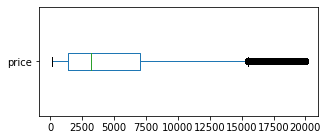

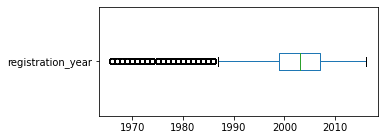

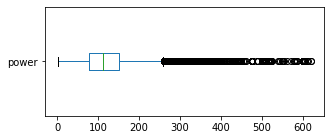

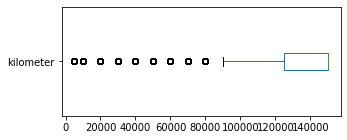

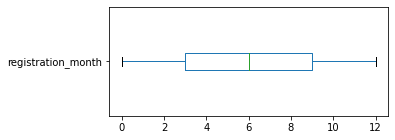

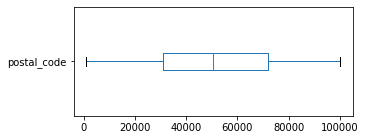

In [31]:
box_plot_df(df)

Все числовые столбци кроме registration_month и postal_code имеют достаточно длиные хвосты

In [32]:
def hist_plot_df(df, bins_N):
    list_of_columns = list(df.select_dtypes(include='number').columns)
    for col in list_of_columns:
        df[[col]].plot(kind='hist', bins=bins_N, histtype='step', linewidth=1, 
                       alpha=0.7, label=col, grid=True, figsize=(7, 7),
                      xlabel = col, ylabel = 'Кол-во')
        plt.title('Гистограмма по столбцу '+col)
        plt.xlabel(col)
        plt.ylabel('Кол-во значений')
        plt.show()

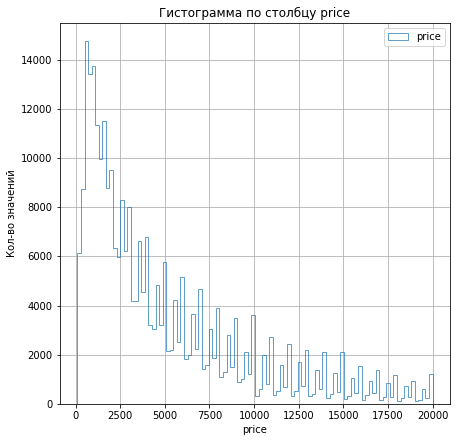

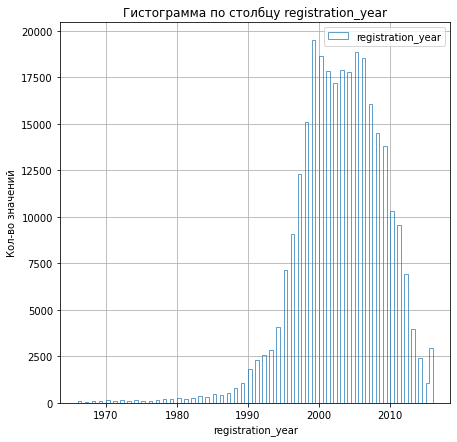

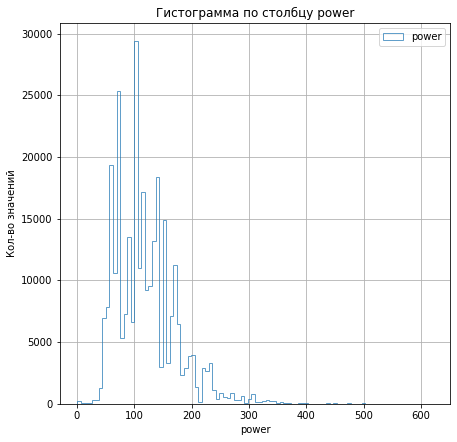

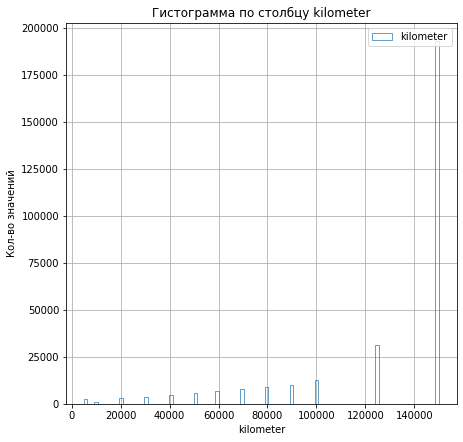

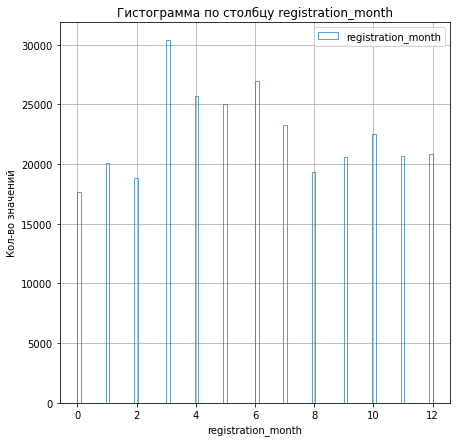

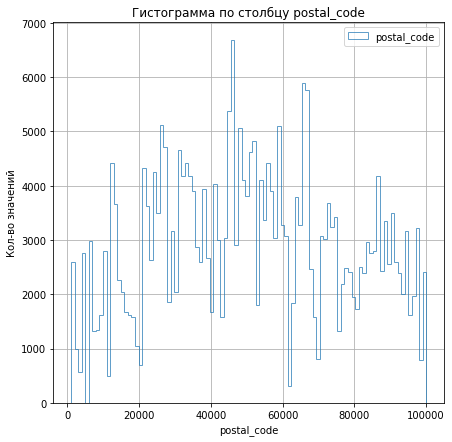

In [33]:
hist_plot_df(df, 100)

- price' - смещение к низким значениям
- registration_year - странный всплекск на 2016 после плавного спуска с наибольшего количества на ~ 2005 году
- power - есть самые массовые модели двигателей дающие пики
- kilometer - можно рассмотреть как категорийный признак

Рассмотрим категорийные признаки полсле заполнения пропусков

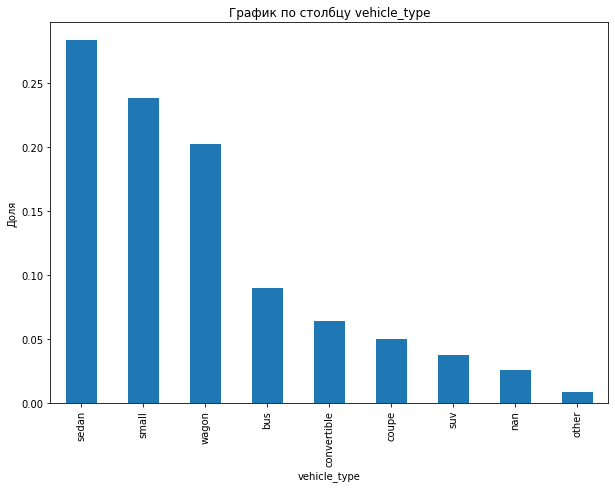

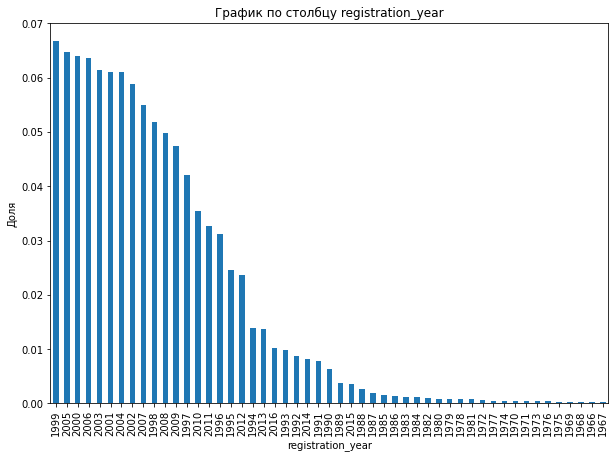

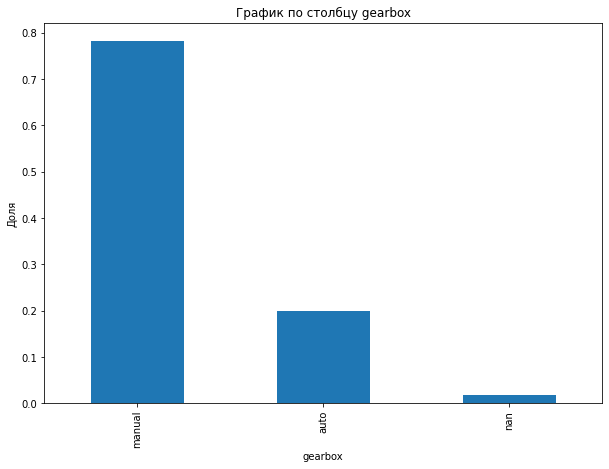

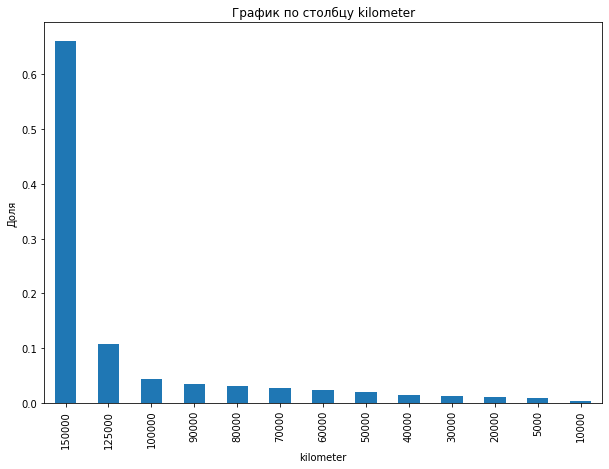

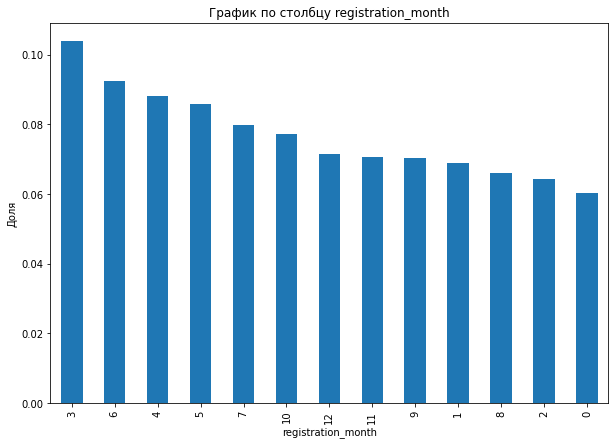

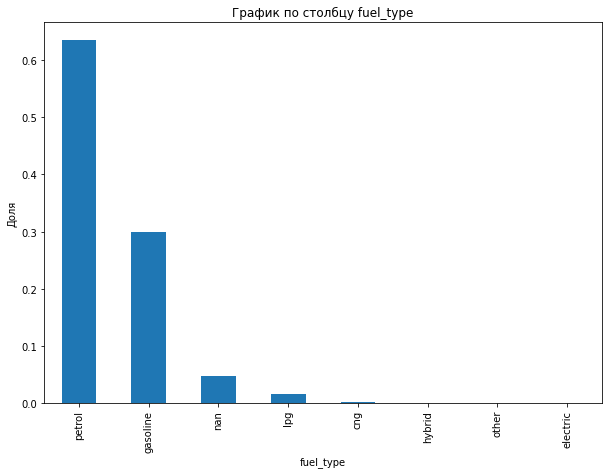

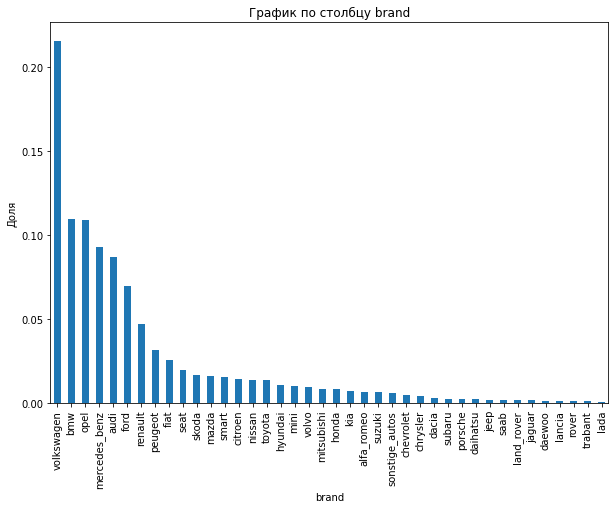

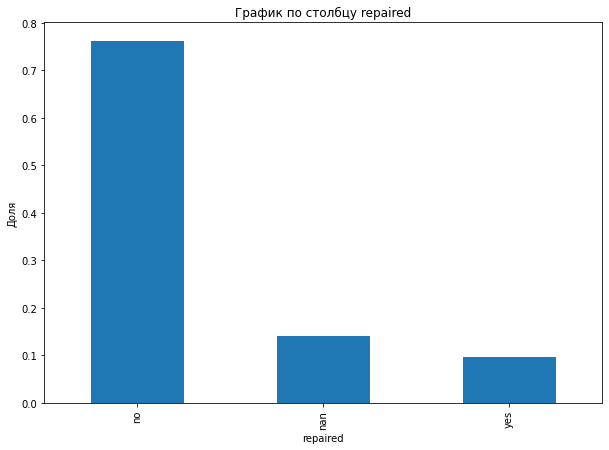

In [34]:
list_of_columns_bar = ['vehicle_type', 'registration_year', 'gearbox',
       'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired']
for col in list_of_columns_bar:
    ax = df.value_counts(subset=col, ascending=False, normalize=True).plot.bar(figsize=(10, 7)) #, grid=True
    plt.title('График по столбцу '+col)
    plt.xlabel(col)
    plt.ylabel('Доля')
    plt.show()

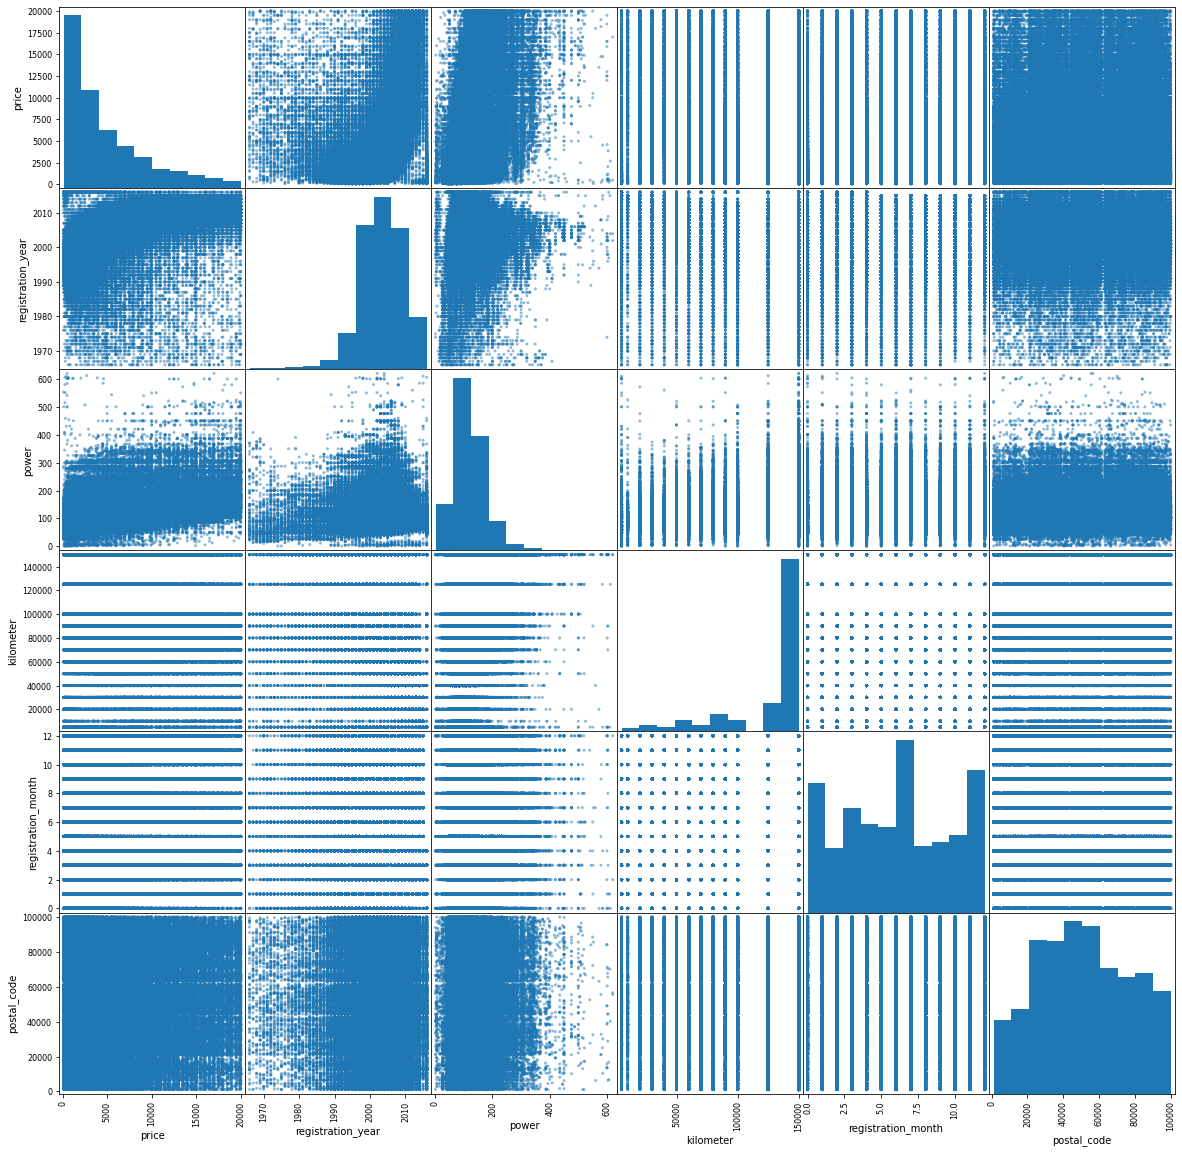

In [35]:
pd.plotting.scatter_matrix(df, figsize=(20, 20));

- Есть связь price и registration_year - всязь не линейная, поэтому при обучении линейной регрессии registration_year сделаем категорией. (можно было извлечь корень) 
- 'power' связан с ценой линейно, после ~ 2005 кол-во мощных машин снижается
- registration_month и postal_code - не информативен

Рассмотрим Коэффициенты корреляции

/opt/conda/lib/python3.9/site-packages/phik/data_quality.py:59: UserWarning: The number of unique values of variable postal_code is large: 8112. Are you sure this is not an interval variable? Analysis for pairs of variables including postal_code can be slow.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/phik/bivariate.py:241: UserWarning: Many cells: 2344368. Are interval variables set correctly?
  warnings.warn(


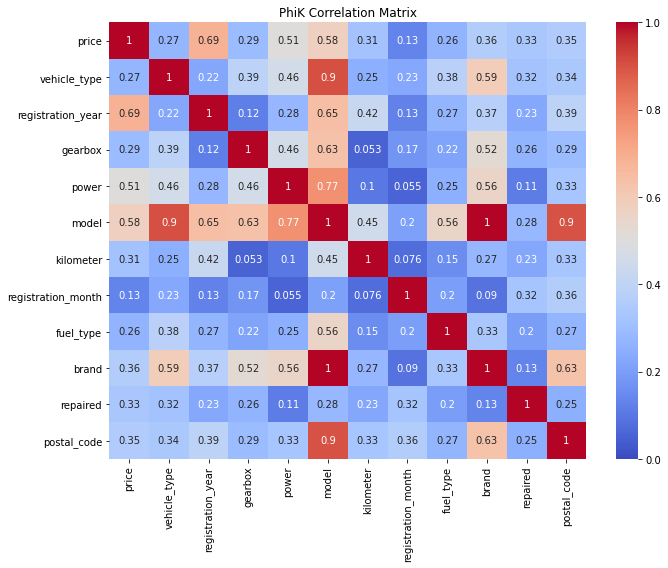

In [36]:
phik_matrix_1 = df.phik_matrix(interval_cols=['price', 'power', 'registration_year', 'kilometer'])
plt.figure(figsize=(10, 8))
sns.heatmap(phik_matrix_1, annot=True, cmap='coolwarm', vmin=0, vmax=1)
plt.title('PhiK Correlation Matrix')
plt.tight_layout()
plt.show()

- brand и postal_code связаны с model. По видимому в модели машин распределены в зависимости от местности. Для исключения мультиколениарности исключим brand и postal_code.

In [37]:
df.columns

Index(['price', 'vehicle_type', 'registration_year', 'gearbox', 'power',
       'model', 'kilometer', 'registration_month', 'fuel_type', 'brand',
       'repaired', 'postal_code'],
      dtype='object')

Выбираем только нужные столбцы и дубликаты оставим

In [38]:
df = df[['price', 'vehicle_type', 'registration_year', 'gearbox', 'power',
       'model', 'kilometer', 'fuel_type', 'repaired']].reset_index(drop=True)

In [39]:
display(df.duplicated().sum())

38874

## Обучение моделей

### Подготовка

- Для LinearRegression все столбцы будут категориальными - кроме power - числовой , 
- Для других моделей 'power', 'registration_year', 'kilometer' - числовые

In [40]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

In [41]:
ohe_columns_0 = ['gearbox', 'repaired']
num_columns_0 = ['power', 'registration_year', 'kilometer']
cat_columns_0 = ['model', 'vehicle_type', 'fuel_type']
target_0 = ['price']
list_of_columns_for_train_total_0 = ohe_columns_0 + num_columns_0 + cat_columns_0 

In [42]:
ohe_columns_lin = ['gearbox', 'repaired', 'model', 'registration_year', 'vehicle_type', 'fuel_type', 'kilometer']
num_columns_lin = ['power']
cat_columns_lin = []
target_lin = ['price']
list_of_columns_for_train_total_lin = num_columns_lin + cat_columns_lin + ohe_columns_lin 

In [43]:
def separation_df (df, target, list_for_train): 
    X = df.drop(target, axis=1)
    X = X[list_for_train]
    y = df[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE) 
    print(X_train.shape)
    print(X_test.shape)
    print(y_train.shape)
    print(y_test.shape)
    return X_train, X_test, y_train, y_test

In [44]:
X_train_0, X_test_0, y_train_0, y_test_0 = separation_df (df, target_0, list_of_columns_for_train_total_0)

(218757, 8)
(72920, 8)
(218757, 1)
(72920, 1)


In [45]:
X_train_lin, X_test_lin, y_train_lin, y_test_lin = separation_df (df, target_lin, list_of_columns_for_train_total_lin)

(218757, 8)
(72920, 8)
(218757, 1)
(72920, 1)


In [46]:
ohe_pipe_0 = Pipeline(
    [
        (
            'simpleImputer_before_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
        ),
        (
            'simpleImputer_after_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

In [47]:
safe_target_encoder = TargetEncoder(cols=cat_columns_0)

In [48]:
data_preprocessor_0 = ColumnTransformer(
    [
        ('cat', safe_target_encoder, cat_columns_0),  
        ('ohe', ohe_pipe_0, ohe_columns_0),
        ('num', StandardScaler(), num_columns_0)
    ],
    remainder='passthrough'
)

In [49]:
pipe_final_0 = Pipeline(
    [
        ('preprocessor', data_preprocessor_0),
        ('models', LinearRegression())
    ]
)

In [50]:
ohe_pipe_lin = Pipeline(
    [
        (
            'simpleImputer_before_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
        ),
        (
            'simpleImputer_after_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

In [51]:
data_preprocessor_lin = ColumnTransformer(
    [
        ('ohe', ohe_pipe_lin, ohe_columns_lin),
        ('num', StandardScaler(), num_columns_lin)
            ], 
    remainder='passthrough'
)

In [52]:
pipe_final_lin = Pipeline(
    [
        ('preprocessor', data_preprocessor_lin),
        ('models', LinearRegression())
    ]
)

In [53]:
param_grid_lin = [
    
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler()] 
    }
] 

In [54]:
param_grid_1 = [
    
    {
        'models': [KNeighborsRegressor()],  
        'models__n_neighbors': [10]
    }
] 

In [55]:
param_grid_2 = [
    
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__min_samples_leaf': [2], 
        'models__max_depth': [15, 20, 25] 
    } 
] 

### Непосредственно обучение

#### LinearRegression

In [56]:
grid_0 = GridSearchCV(
    pipe_final_lin, 
    param_grid=param_grid_lin, 
    cv=5,
    scoring='neg_root_mean_squared_error', 
    n_jobs=-1
)

In [57]:
grid_0.fit(X_train_0, y_train_0)
print('Лучшая модель и её параметры:\n\n', grid_0.best_estimator_)

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_before_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False)),
                                                                  ('simpleImputer_after_ohe',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                              

In [58]:
result_0 = pd.DataFrame(grid_0.cv_results_)
result_0 = result_0.sort_values('rank_test_score')
display(result_0.head())

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_models,param_preprocessor__num,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,26.195047,0.911480,0.792389,0.059141,LinearRegression(),StandardScaler(),"{'models': LinearRegression(), 'preprocessor__...",-2055.387791,-2059.035859,-2048.761534,-2055.085982,-2039.904475,-2051.635128,6.732421,1
1,26.888332,1.259362,0.787552,0.015534,LinearRegression(),MinMaxScaler(),"{'models': LinearRegression(), 'preprocessor__...",-2055.387791,-2059.035859,-2048.761534,-2055.085982,-2039.904475,-2051.635128,6.732421,1


In [59]:
display('Метрика RMSE для лучшей модели LinearRegression:', grid_0.best_score_*-1)

'Метрика RMSE для лучшей модели LinearRegression:'

2051.6351283703852

#### KNeighborsRegressor

In [60]:
grid_1 = GridSearchCV(
    pipe_final_0, 
    param_grid=param_grid_1, 
    cv=5,
    scoring='neg_root_mean_squared_error', 
    n_jobs=-1
)

In [61]:
grid_1.fit(X_train_0, y_train_0)
print('Лучшая модель и её параметры:\n\n', grid_1.best_estimator_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  TargetEncoder(cols=['model',
                                                                      'vehicle_type',
                                                                      'fuel_type']),
                                                  ['model', 'vehicle_type',
                                                   'fuel_type']),
                                                 ('ohe',
                                                  Pipeline(steps=[('simpleImputer_before_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='firs

In [62]:
result_1 = pd.DataFrame(grid_1.cv_results_)
result_1 = result_1.sort_values('rank_test_score')
display(result_1.head())

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_models,param_models__n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.005091,0.027568,4.430406,0.128526,KNeighborsRegressor(),10,"{'models': KNeighborsRegressor(), 'models__n_n...",-1901.827225,-1861.037223,-1876.163211,-1892.043158,-1877.232123,-1881.660588,14.068736,1


In [63]:
display('Метрика RMSE для лучшей модели KNeighborsRegressor:', grid_1.best_score_*-1)

'Метрика RMSE для лучшей модели KNeighborsRegressor:'

1881.6605881643368

#### DecisionTreeRegressor

In [64]:
grid_2 = GridSearchCV(
    pipe_final_0, 
    param_grid=param_grid_2, 
    cv=5,
    scoring='neg_root_mean_squared_error', 
    n_jobs=-1
)

In [65]:
grid_2.fit(X_train_0, y_train_0)
print('Лучшая модель и её параметры:\n\n', grid_2.best_estimator_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  TargetEncoder(cols=['model',
                                                                      'vehicle_type',
                                                                      'fuel_type']),
                                                  ['model', 'vehicle_type',
                                                   'fuel_type']),
                                                 ('ohe',
                                                  Pipeline(steps=[('simpleImputer_before_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='firs

In [66]:
result_2 = pd.DataFrame(grid_2.cv_results_)
result_2 = result_2.sort_values('rank_test_score')
display(result_2.head())

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_models,param_models__max_depth,param_models__min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1,1.165689,0.028970,0.081350,0.002857,DecisionTreeRegressor(random_state=42),20,2,{'models': DecisionTreeRegressor(random_state=...,-1783.910619,-1804.747780,-1796.209658,-1805.155501,-1789.554599,-1795.915631,8.343280,1
0,1.074522,0.022021,0.078267,0.005515,DecisionTreeRegressor(random_state=42),15,2,{'models': DecisionTreeRegressor(random_state=...,-1794.549840,-1812.620861,-1787.522239,-1808.899386,-1788.202985,-1798.359062,10.484180,2
2,1.206988,0.011149,0.086257,0.003561,DecisionTreeRegressor(random_state=42),25,2,{'models': DecisionTreeRegressor(random_state=...,-1798.797245,-1818.262661,-1807.051132,-1809.742440,-1799.292750,-1806.629246,7.216242,3


In [67]:
display('Метрика RMSE для лучшей модели DecisionTreeRegressor :', grid_2.best_score_*-1)

'Метрика RMSE для лучшей модели DecisionTreeRegressor :'

1795.9156313041108

### LightGBM

In [68]:
pipe_final_GBM = Pipeline([
    ('preprocessor', data_preprocessor_0),  
    ('model', LGBMRegressor(boosting_type='gbdt', verbose=0, random_state=RANDOM_STATE))
])

In [69]:
gbm_params = {
    'model__learning_rate': [0.3, 0.4], 
    'model__n_estimators': [300, 400], 
    'model__num_leaves': [40, 50] 
}

In [70]:
grid_gbm = GridSearchCV(pipe_final_GBM, gbm_params, cv=5,scoring='neg_root_mean_squared_error') 

In [71]:
grid_gbm.fit(X_train_0, y_train_0)
print('Лучшая модель и её параметры:\n', grid_gbm.best_params_)

/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004794 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.180299 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005190 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005753 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.180829 seconds.
You can set `force_col_wise=true` to remove the overhead.


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005085 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005433 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.180583 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.176870 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.102462 seconds.
You can set `force_col_wise=true` to remove the overhead.


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006945 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004802 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008286 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.095961 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.092577 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.406975 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.384025 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.498586 seconds.
You can set `force_col_wise=true` to remove the overhead.


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.095196 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005890 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008338 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.178058 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005677 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005734 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.200548 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005688 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004878 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005909 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.100326 seconds.
You can set `force_col_wise=true` to remove the overhead.


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.486840 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.095369 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.180624 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005197 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.085018 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005503 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.096199 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004505 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.098957 seconds.
You can set `force_col_wise=true` to remove the overhead.


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005260 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.096074 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005824 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Лучшая модель и её параметры:
 {'model__learning_rate': 0.3, 'model__n_estimators': 400, 'model__num_leaves': 50}


In [72]:
result_gbm = pd.DataFrame(grid_gbm.cv_results_)
result_gbm = result_gbm.sort_values('rank_test_score')
display(result_gbm.head(5))

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__learning_rate,param_model__n_estimators,param_model__num_leaves,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
3,33.713678,17.065240,1.086833,0.036942,0.3,400,50,"{'model__learning_rate': 0.3, 'model__n_estima...",-1548.265253,-1537.390033,-1535.143539,-1543.506959,-1519.785670,-1536.818291,9.685175,1
1,11.438924,0.865436,0.843227,0.045165,0.3,300,50,"{'model__learning_rate': 0.3, 'model__n_estima...",-1555.253480,-1543.021784,-1539.281842,-1545.878051,-1525.143334,-1541.715698,9.827202,2
2,12.536539,0.411327,1.038765,0.040794,0.3,400,40,"{'model__learning_rate': 0.3, 'model__n_estima...",-1546.670582,-1544.929678,-1542.866723,-1540.834019,-1540.261182,-1543.112437,2.422560,3
0,10.834186,1.501141,0.799788,0.002913,0.3,300,40,"{'model__learning_rate': 0.3, 'model__n_estima...",-1553.674670,-1554.025630,-1548.582763,-1546.238765,-1546.515384,-1549.807442,3.400632,4
6,15.972547,6.506055,0.966694,0.043261,0.4,400,40,"{'model__learning_rate': 0.4, 'model__n_estima...",-1559.086499,-1551.861372,-1551.166626,-1551.025173,-1540.957516,-1550.819437,5.776682,5


## Анализ моделей

В исходном датафрейме представлено - 354369 rows × 16 columns, 
    
**Часть признаков для прогнозирования не использовалась:**
- date_created -  размах 2 года - для прогнозирования неинформативен
- last_seen - размах месяц - для прогнозирования неинформативен
- date_crawled - размах месяц - для прогнозирования неинформативен
- registration_month - есть месяц 0  -  для прогноза важен год, поэтому столбец не использовался для прогнозирования
- number_of_pictures - везде 0   - для прогнозирования неинформативен
- brand - связаны с model. Коэфф. колинеарности 0.99 - Для исключения мультиколениарности brand не использовался для прогнозирования.
- postal_code и brand - связаны с model. По видимому в модели машин распределены в зависимости от местности, а это влияет на цену. Для исключения мультиколениарности postal_code не использовался для прогнозирования.

**Из оставшихся признаков имеются пропуски до 20% по отдельным столбцам:**
- vehicle_type          37490 - Заполним пропуск на nan, несмотря на наличие категории other
- gearbox               19833 - Возможно коробка снята - Заполним пропуск на nan,
- model                 19705 - Возможно модели не было в выпадающем списке на сайте - Заменим пропуск на название brand это позволит исключить brand из признаков.
- fuel_type             32895 - Возможно многотопливный - Заполним пропуск на nan, несмотря на наличие категории other
- repaired              71154 - Чувствительный параметр, ремонт часто пробуют скрыть - Заполним пропуск на nan,

**Призкаков имеют выбивающиеся значения:**
- price = 0 встречается 10772 - Возможно это для привлечения внимания, или предлагают металолом. Для околонулевой цены высока доля пропусков, сама цена не является рыночной, удалим объявления с price < 100. 
- registration_year - можно рассматривать как категорийный признак, уберем машины из будущего начиная с 05.2016 года (т.к. данные от 04.2016 года) и машины старше 50 лет т.к это уже особая категория раритета или уже металолома.
- Данные  в столбце **registration_year** - по всей видимости некорректно заполняются пользователями и это не единичные ошибки, а целенаправленное искажение, **нужен контроль даты на основе сканов документов СТС на машину**
- В 2016 относительно 2015 резкий рост регистаций автомобилей, а также значительное количество месяца - 0.
- power = 0 встречается 40225 раз, есть значение 20000 л.с что нереально. - Удалим строки с power 0 или более 625 л.с
- kilometer - выражен числом, скорее похож на категорийный признак


**Распределение числовых значений:**

- price' - смещение к низким значениям
- registration_year - странный всплекск на 2016 после плавного спуска с наибольшего количества на ~ 2005 году
- power - есть самые массовые модели двигателей дающие пики
- kilometer - можно рассмотреть как категорийный признак
- Есть связь price и registration_year - сязь не линейная, поэтому при обучении линейной регрессии registration_year сделаем категорией.
- 'power' связан с ценой линейно, после ~ 2005 кол-во мощных машин снижается

**После обработки осталось 291677 строк х 9 признаков (8 признаков + целевой)**

- Для LinearRegression все столбцы будут категориальными - кроме power - числовой , 
- Для других моделей 'power', 'registration_year', 'kilometer' - числовые

In [73]:
col_tab = ['RMSE_train', 't_learn', 't_pred']
name_model = ['LinearRegression', 'KNeighborsRegressor', 'DecisionTreeRegressor', 'LightGBM']
final_tab = pd.DataFrame(index=name_model, columns=col_tab)
final_tab['RMSE_train'] = (-result_0.iloc[0]['mean_test_score'], -result_1.iloc[0]['mean_test_score'], 
                           -result_2.iloc[0]['mean_test_score'], -result_gbm.iloc[0]['mean_test_score'])
final_tab['t_learn'] =  (result_0.iloc[0]['mean_fit_time'], result_1.iloc[0]['mean_fit_time'], 
                         result_2.iloc[0]['mean_fit_time'], result_gbm.iloc[0]['mean_fit_time'])
final_tab['t_pred'] =  (result_0.iloc[0]['mean_score_time'], result_1.iloc[0]['mean_score_time'], 
                        result_2.iloc[0]['mean_score_time'], result_gbm.iloc[0]['mean_score_time'])
display(final_tab)

,RMSE_train,t_learn,t_pred
LinearRegression,2051.635128,26.195047,0.792389
KNeighborsRegressor,1881.660588,1.005091,4.430406
DecisionTreeRegressor,1795.915631,1.165689,0.081350
LightGBM,1536.818291,33.713678,1.086833


В рамках проекта обучены 3 простые модели и 1 модель бустинга.

- По результатам сравнения RMSE_train лидером качества стала модель LightGBM.


- Вторая модель KNeighborsRegressor
- Третья DecisionTreeRegressor
- Четвертая LinearRegression 
- Все модели подходят по качеству

Проверим модель-лидер -  LightGBM на тестовой выборке 

In [74]:
predict_LGB_1= grid_gbm.best_estimator_.predict(X_test_0)

In [75]:
rmse_LGB_1 = root_mean_squared_error(y_test_0, predict_LGB_1)
print(f'Значение метрики RMSE для лучшей моделиLightGBM  на тестовых данных: {rmse_LGB_1}')

Значение метрики RMSE для лучшей моделиLightGBM  на тестовых данных: 1518.4635923265569


Значение метрики RMSE для выбранной модели на тестовой выборке не ухудшается - модель ведет себя стабильно.

Её можно передать заказчику

- Из простых моделей KNN показал лучшее качество, но долгое время предсказания. Пользователь ждать не будет.
- LightGBM показал лучший результат, но время обучения велико. Время предсказания приемлемо - Для заказчика рекомендуется именно эта модель. Периодическое обучение можно проводить во время наименьшей активности пользователей.
- Возможно применение модели  DecisionTreeRegressor - для предварительной оценки.

Если заказчик причастен к созданию формы для заполнения информацией по машине, То следует 
- ввести контроль по дате регистрации машины по скану докумментов 
- стимулировать пользователей добавлять фотографии, в дальнейшем из них можно будет контролировать Модель, Кузов
- вести БД моделей и педлагать заполнение информации по машине на основе это БД.
- Дополнить БД новыми признаками для улучшения точности предсказания